
# **Federated Learning for Image Classification**


In [2]:
!pip install "numpy<2.0" matplotlib tensorflow tensorflow_federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
INFO: pip is looking at multiple versions of tensorflow-federated to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.4/58.4 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 45.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of grpcio-tools to determine which version is compatible with other requirements. This could take a while.
INFO: This is taking longer than usual. You might need to provide the dependency resolver with stricter constraints to reduce

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_federated as tff
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For consistent results
np.random.seed(0)
tf.random.set_seed(0)

ERROR:jax._src.xla_bridge:Jax plugin configuration error: Exception when calling jax_plugins.xla_cuda12.initialize()
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/jax/_src/xla_bridge.py", line 438, in discover_pjrt_plugins
    plugin_module.initialize()
  File "/usr/local/lib/python3.10/dist-packages/jax_plugins/xla_cuda12/__init__.py", line 85, in initialize
    options = xla_client.generate_pjrt_gpu_plugin_options()
AttributeError: module 'jaxlib.xla_client' has no attribute 'generate_pjrt_gpu_plugin_options'


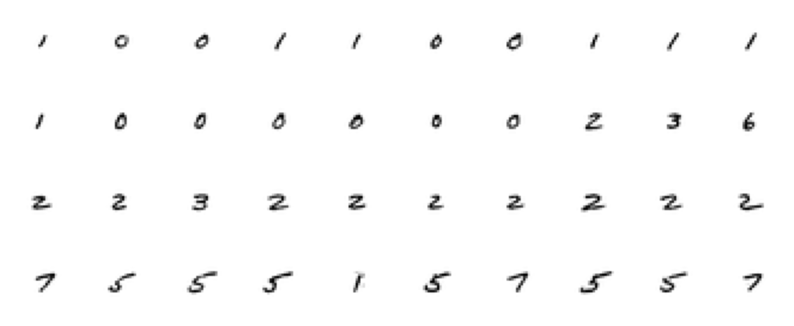

In [2]:
# Load EMNIST dataset
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

# Visualize examples from a single client
example_dataset = emnist_train.create_tf_dataset_for_client(emnist_train.client_ids[0])

# Plot first 40 images from one client
plt.figure(figsize=(10, 4))
for i, example in enumerate(example_dataset.take(40)):
    plt.subplot(4, 10, i + 1)
    plt.imshow(example['pixels'].numpy(), cmap='gray')
    plt.axis('off')
plt.show()

In [70]:
NUM_CLIENTS = 10
NUM_EPOCHS = 10
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100
PREFETCH_BUFFER = 10
def preprocess(dataset):
    def batch_format_fn(element):
        """Flatten and format the data into an OrderedDict."""
        # Accessing the correct keys after batching:
        return collections.OrderedDict(
            # Reshape pixels and label within the batch
            x=tf.reshape(element['pixels'], [-1, 28, 28, 1]),
            y=tf.reshape(element['label'], [-1, 1])
        )

    # Applying batch after mapping to ensure correct element structure:
    # Changed order of operations: map before batch
    return dataset.repeat(NUM_EPOCHS).shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).map(batch_format_fn).prefetch(PREFETCH_BUFFER)

In [71]:
preprocessed_example_dataset = preprocess(example_dataset)
sample_batch = tf.nest.map_structure(lambda x: x.numpy(),next(iter(preprocessed_example_dataset)))
sample_batch

OrderedDict([('x',
              array([[[[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      ...,
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
         

In [72]:
def make_federated_data(client_data , client_ids):
  return [
      preprocess(client_data.create_tf_dataset_for_client(x))
      for x in client_ids
  ]

In [73]:
from tensorflow.keras.layers import LeakyReLU

def create_keras_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), input_shape=(28, 28, 1)),
        LeakyReLU(alpha=0.1),  # Leaky ReLU activation
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Conv2D(64, (3, 3)),
        LeakyReLU(alpha=0.1),
        tf.keras.layers.MaxPooling2D((2, 2)),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128),
        LeakyReLU(alpha=0.1),
        tf.keras.layers.Dense(10, activation='softmax')  # Output layer with softmax for classification
    ])
    return model


In [60]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

In [61]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.5),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0))

In [62]:
train_state = training_process.initialize()

In [63]:
import random

In [80]:
# Select a fixed set of 100 clients
fixed_client_ids = np.random.choice(emnist_train.client_ids, size=300, replace=False)

# Number of training rounds
NUM_ROUNDS = 10

for round_num in range(NUM_ROUNDS):
    print(f'Training round {round_num + 1}')

    # Use the fixed set of clients for each round
    federated_train_data = make_federated_data(emnist_train, fixed_client_ids)

    # Perform training on the selected clients
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics

    print(f'Round {round_num + 1}, metrics={train_metrics}')


Training round 1
Round 1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.95692444), ('loss', 0.46800116), ('num_examples', 300170), ('num_batches', 15074)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Training round 2
Round 2, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.96943396), ('loss', 0.28595448), ('num_examples', 300170), ('num_batches', 15074)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])
Training round 3
Round 3, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.9622647), ('loss', 0.41561604), ('num_examples', 300170), ('num_batches', 15074)]))])), ('aggregator',

In [81]:
import random

In [86]:
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
evaluation_state = evaluation_process.initialize()

# Get model weights from the training process
model_weights = training_process.get_model_weights(train_state)

# Set the model weights in the evaluation state
evaluation_state = evaluation_process.set_model_weights(evaluation_state, model_weights)

# Create test federated data (we'll evaluate on a few test clients)
federated_test_data = make_federated_data(emnist_train, random.sample(emnist_train.client_ids, 30))

# Evaluate the model
evaluation_output = evaluation_process.next(evaluation_state, federated_test_data)

# Print evaluation metrics
print(f'Evaluation Metrics: {evaluation_output.metrics}')

Evaluation Metrics: OrderedDict([('distributor', ()), ('client_work', OrderedDict([('eval', OrderedDict([('current_round_metrics', OrderedDict([('sparse_categorical_accuracy', 0.94610584), ('loss', 0.18721007), ('num_examples', 30430), ('num_batches', 1528)])), ('total_rounds_metrics', OrderedDict([('sparse_categorical_accuracy', 0.94610584), ('loss', 0.18721007), ('num_examples', 30430), ('num_batches', 1528)]))]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', ())])


In [87]:
for batch in federated_test_data:
    print(batch)
    break  # Just print the first batch to inspect


<_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


In [88]:
import seaborn as sns
from sklearn.metrics import  accuracy_score

1/1 [==============================] - 0s 46ms/step


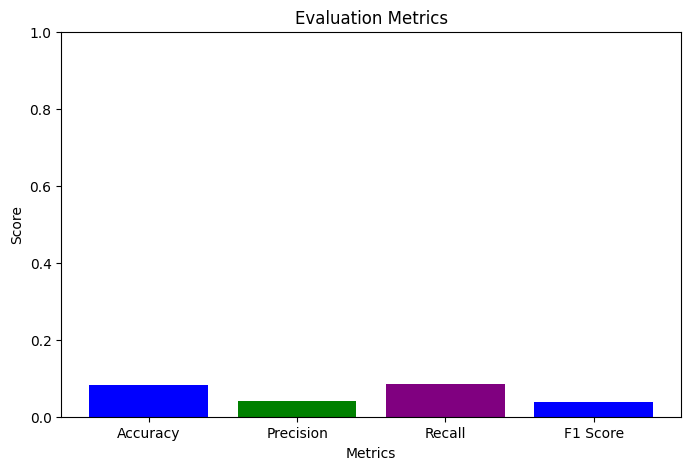

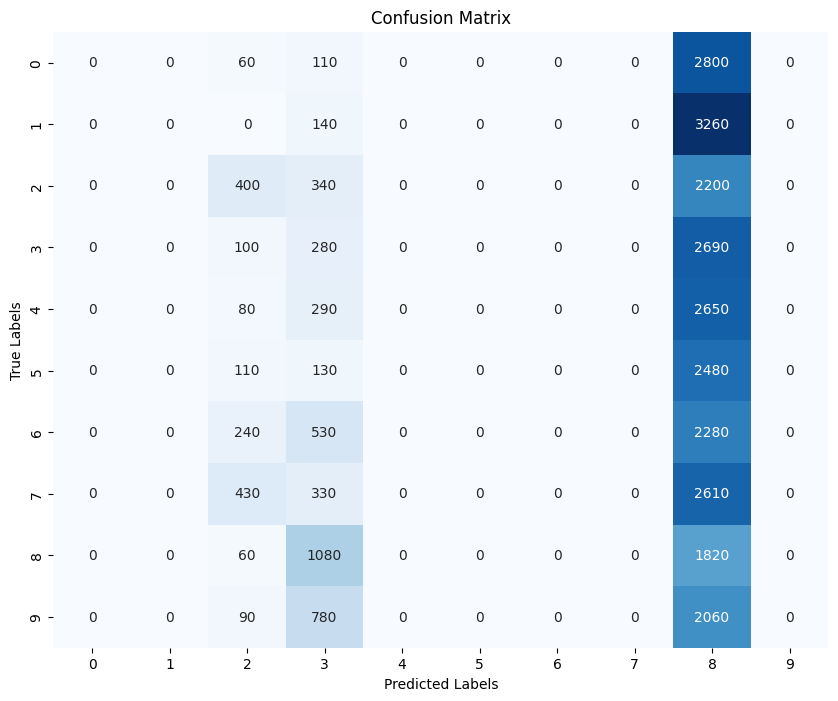

In [89]:
def compute_custom_metrics(model, test_data):
    y_true = []
    y_pred = []

    # Iterate through client data
    for client_data in test_data:
        # Iterate through batches for each client
        for batch in client_data:
            # Access features and labels using the keys 'x' and 'y'
            x = batch['x']
            y = batch['y']

            # Make predictions using the model
            predictions = model.predict(x)
            predicted_labels = np.argmax(predictions, axis=1)

            # Flatten y_true and convert to numpy
            y_true.extend(y.numpy().flatten())
            y_pred.extend(predicted_labels)

    # Calculate precision, recall, f1-score,Accuracy  and confusion matrix
    precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
    recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)

    # Plot Precision, Recall,Accuracy  and F1 Score as a bar chart
    metrics = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
    plt.figure(figsize=(8, 5))
    plt.bar(metrics.keys(), metrics.values(), color=['blue', 'green', 'purple'])
    plt.title('Evaluation Metrics')
    plt.xlabel('Metrics')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.show()

    # Plot the Confusion Matrix as a heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

# Assuming you have your model and test data ready
compute_custom_metrics(create_keras_model(), federated_test_data)